In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
from decipher.datasets.decipher_data import Decipher
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import gridspec
from matplotlib.ticker import FixedLocator
from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, leaves_list
import matplotlib as mpl

from collections import namedtuple

In [19]:
PROJECT_BASE = Path("/home/samson/kornhill/work-vault/2-Projects/decipher/decipher-v4")

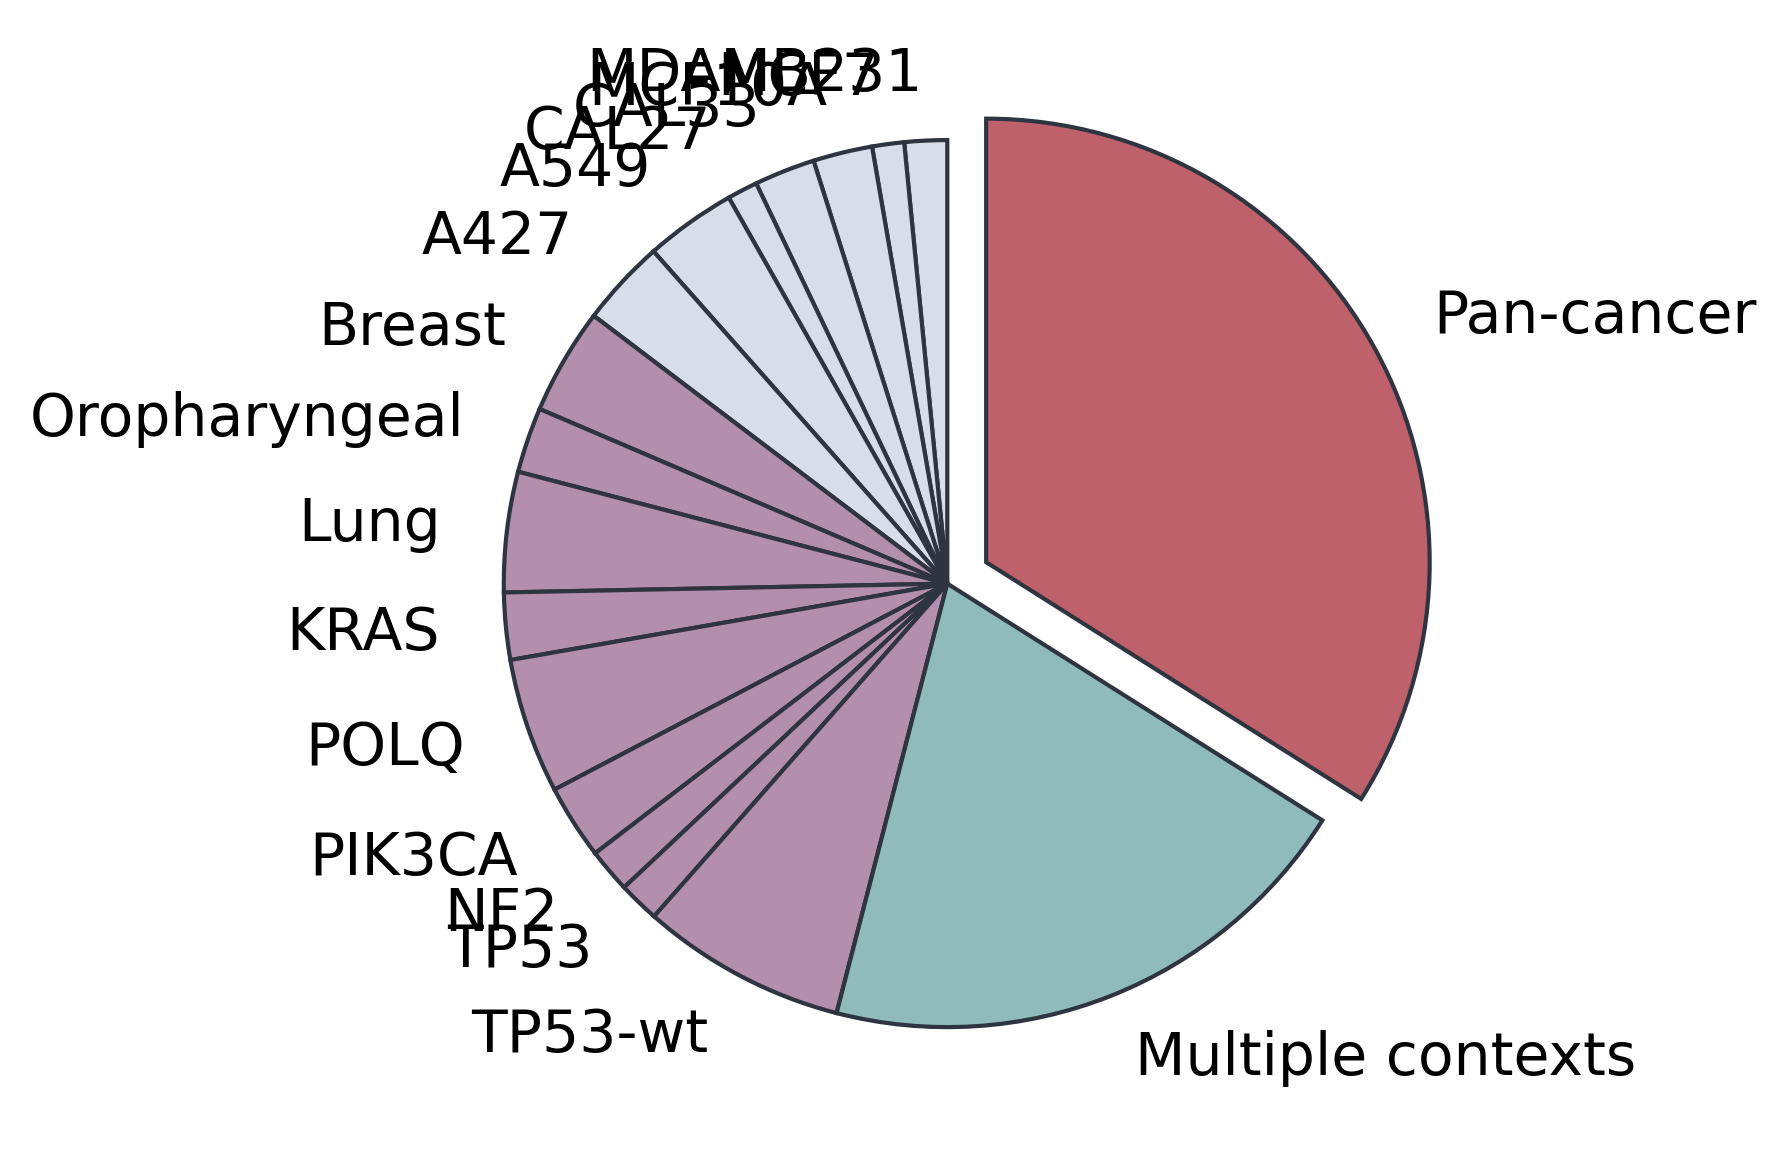

In [21]:
def to_set_of_sets(values): 
    set_of_sets = []
    for value in values: 
        set_of_sets.append(frozenset(value))

    return set(set_of_sets)

def get_pie_color(decipher, name): 
    if name == 'pan-cancer': 
        return '#bf616a'
    
    elif name == 'multi': 
        return '#8fbcbb'

    elif name in decipher.combo_map.keys(): 
        return '#b48ead'
    
    elif name in decipher.cell_lines: 
        return '#d8dee9'
    
    raise ValueError(f"Invalid name ({name})")

def categorize_hit(hits):
    tissues = list(decipher.combo_map.keys())
    cell_lines = ["A549", "A427", "CAL33", "CAL27", "MDAMB231", "MCF7", "MCF10A"]

    if hits["pan-cancer"]:
        return "pan-cancer"

    tissue = [t for t in tissues if hits[t]]

    if tissue:
        if len(tissue) == 1:
            return tissue[0]
        else:
            return "multi"

    cell_line = [t for t in cell_lines if hits[t]]

    if cell_line:
        if len(cell_line) == 1:
            return cell_line[0]
        else:
            return "multi"

    return None


def plot_pie(data, ax=None, colors=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    explode = [0.1 if i == "Pan-cancer" else 0 for i in data.index]
    ax.pie(
        data.values,
        explode=explode,
        labels=data.index,
        wedgeprops={"linewidth": 1, "edgecolor": "#2e3440"},
        textprops={"fontsize": 14},
        colors=colors,
        labeldistance=1.15,
        **kwargs
    )


all_hits = pd.read_csv(
    PROJECT_BASE / "data/decipher/synthetic-essential-genes/decipher_synthetic_essential_genes.csv",
    index_col=0,
)

conditions = [
    "pan-cancer",
    "MDAMB231",
    "MCF7",
    "MCF10A",
    "CAL33",
    "CAL27",
    "A549",
    "A427",
    "brca",
    "hnsc",
    "nsclc",
    'KRAS', 
    'POLQ', 
    'PIK3CA', 
    'NF2', 
    'TP53', 
    'TP53-wt',
    "multi",
]
# conditions += [f"GROUP{i}" for i in range(1, 13)]
namemap = {
    "pan-cancer": "Pan-cancer",
    "brca": "Breast",
    "hnsc": "Oropharyngeal",
    "nsclc": "Lung",
    "multi": "Multiple contexts",
}

hits = all_hits.loc[all_hits["method"] == "comfortable"].assign(value=True)
# I want to take all hits
# hits = hits.loc[(~hits[["a_is_essential", "b_is_essential"]]).all(axis=1)]
hits = hits.loc[hits["condition"].isin(conditions)]
hits = hits.pivot(index=["geneA", "geneB"], columns="condition", values="value").fillna(False)

# Account for A-B and B-A
categories = {}
seen = []
for index, row in hits.iterrows(): 
    index = frozenset(index)

    if index in seen: 
        _index = tuple(index)
        tmp = hits.loc[[_index, _index[::-1]]]
        row = tmp.any(axis=0)

    categories[index] = categorize_hit(row)
    seen.append(index)

categories = pd.Series(categories)

categories_, counts = np.unique(categories, return_counts=True)
counts = pd.Series(counts, index=categories_)
counts = pd.DataFrame(counts).assign(fraction=counts / counts.sum())
counts = counts.loc[conditions]

colors = [get_pie_color(decipher, name) for name in counts.index]

counts.index = [namemap.get(i, i) for i in counts.index]

fig, ax = plt.subplots(dpi=300)
plot_pie(
    counts[0],
    colors=colors,
    ax=ax,
    startangle=-counts.loc['Pan-cancer', 'fraction'] * 360 + 90,
)


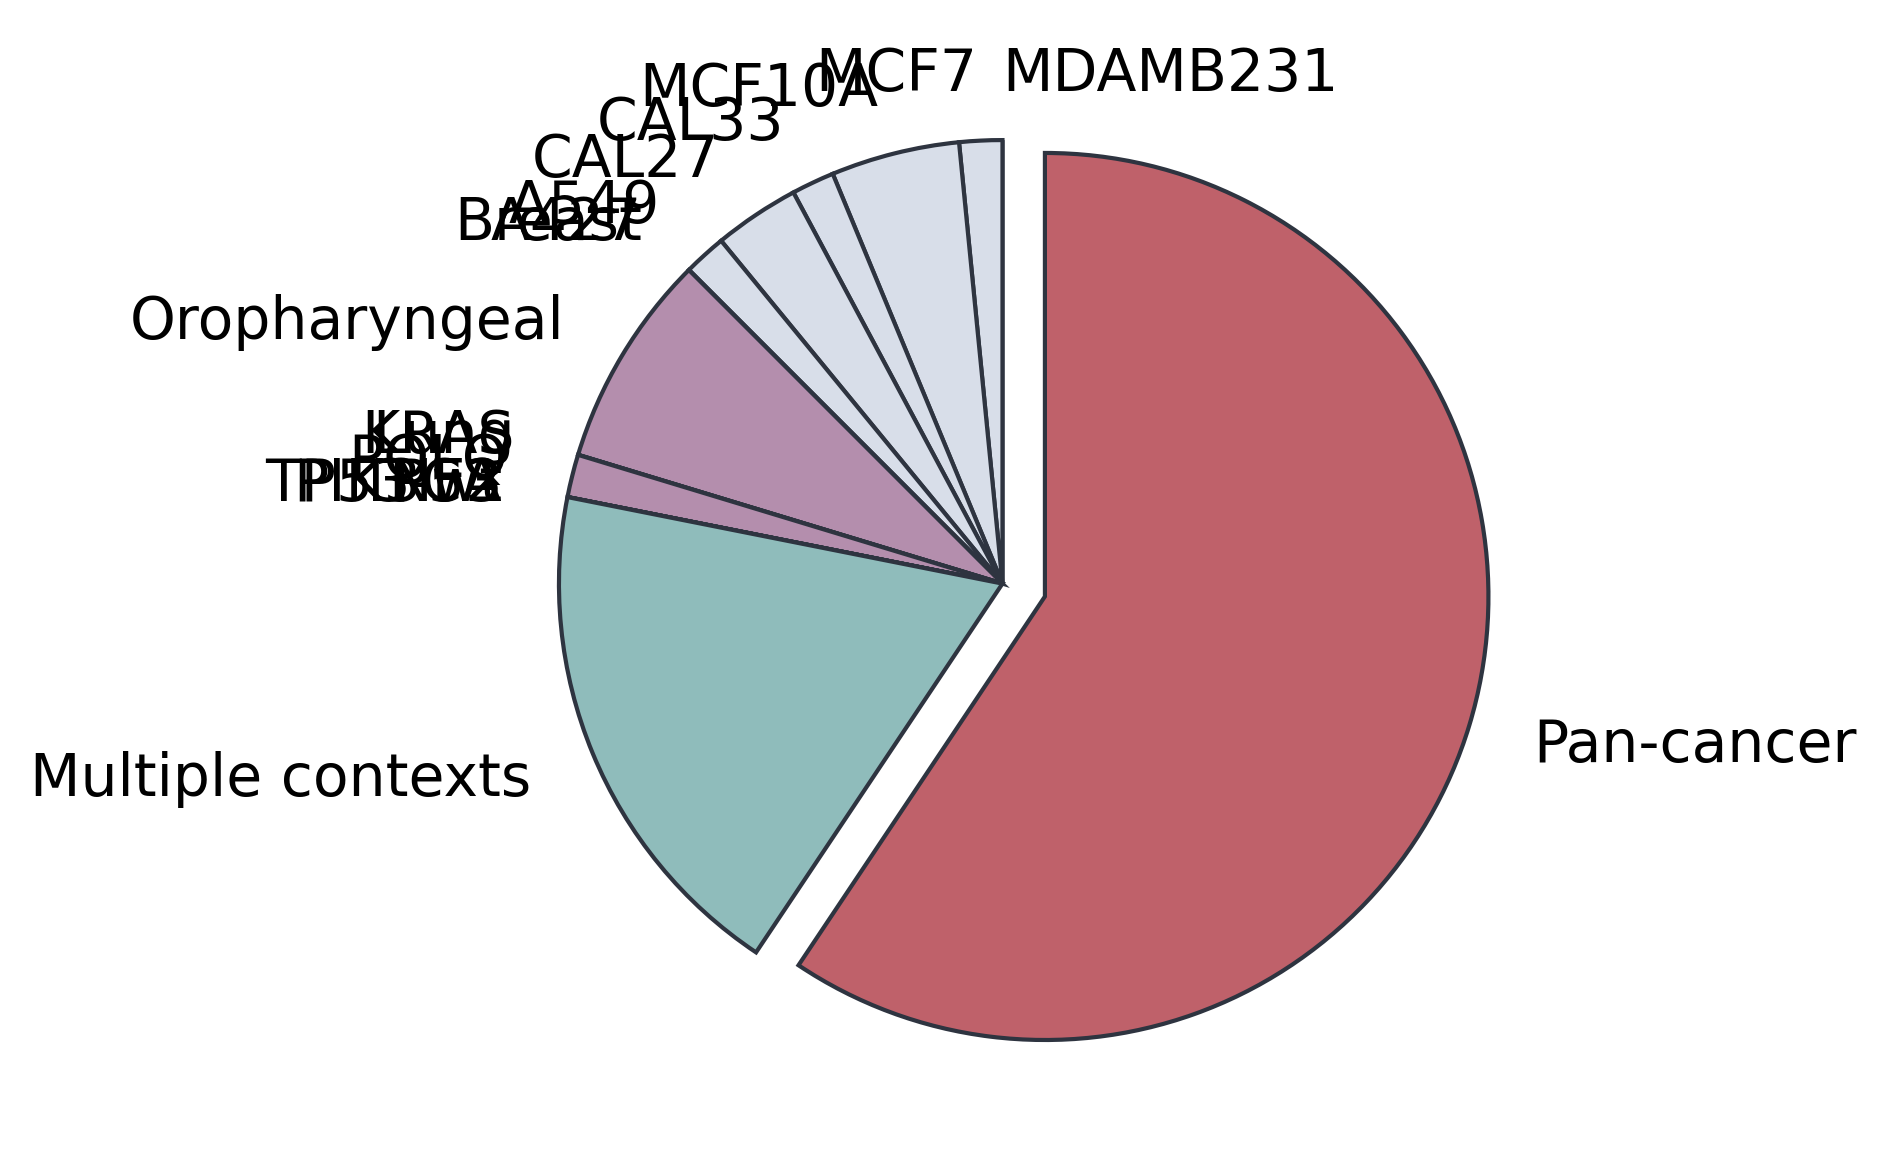

In [23]:
conditions = [
    "pan-cancer",
    "MDAMB231",
    "MCF7",
    "MCF10A",
    "CAL33",
    "CAL27",
    "A549",
    "A427",
    "brca",
    "hnsc",
    "nsclc",
    'KRAS', 
    'POLQ', 
    'PIK3CA', 
    'NF2', 
    'TP53', 
    'TP53-wt',
    "multi",
]
namemap = {
    "pan-cancer": "Pan-cancer",
    "brca": "Breast",
    "hnsc": "Oropharyngeal",
    "nsclc": "Lung",
    "multi": "Multiple contexts",
}


all_essentials = pd.read_csv(
    PROJECT_BASE / "data/decipher/essential-genes/decipher_essential_genes.csv", 
    index_col=0
)

all_essentials_sq = (
    all_essentials.loc[all_essentials["condition"].isin(conditions)]
    .reset_index()
    .assign(value=True)
    .pivot(index="genes", columns="condition", values="value")
    .fillna(False)
)

ess_categories = [categorize_hit(row) for _, row in all_essentials_sq.iterrows()]
ess_categories = pd.Series(ess_categories, index=all_essentials_sq.index)

categories, counts = np.unique(ess_categories, return_counts=True)
counts = pd.Series(counts, index=categories)
counts = pd.DataFrame(counts).assign(fraction=counts / counts.sum())
counts = counts.reindex(conditions).fillna(0)

colors = [get_pie_color(decipher, index) for index in counts.index]
counts.index = [namemap.get(i, i) for i in counts.index]

fig, ax = plt.subplots(dpi=300)
plot_pie(
    counts[0],
    colors=colors,
    ax=ax,
    startangle=-counts.loc['Pan-cancer', 'fraction'] * 360 + 90,
)


In [13]:
highlights = {
    "pan-cancer": [
        ["BRCA1", "PARP1"],
        ["BRCA1", "USP1"],
        ["BRCA1", "APEX2"],
        ["BRCA1", "SMARCA2"],
        ['TIPARP', 'CDKN2B'], 
        ['TIPARP', 'KDM5C'], 
        ['TIPARP', 'KDM6A']
    ],
    "nsclc": [
        ["VRK1", "STK11"],
        ["VRK1", "VHL"],
        ["VRK1", "FBXW7"],
        ["MRE11", "POLE"],
    ],
}



def plot_pancancer_sl_heatmap(data, save_path):
    pancancer_data = data.process("pan-cancer")
    pancan_hmap = draw_heatmap(pancancer_data, [[0], range(1, 4), range(4, 11), [11]])

    return pancan_hmap


def plot_tissue_sl_heatmap(data, save_path):
    tissue_data = []
    for tissue in ["brca", "nsclc", "hnsc"]:
        tissue_data.append(data.process(tissue, ci=5, fdr=0.05, context_only=True))

    tissue_data = pd.concat(tissue_data, axis=1)
    # TODO: The fig_width will need to be changed if the data changes
    tissue_hmap = draw_heatmap(
        tissue_data, [[0], range(1, 4), range(4, 11), [11]], fig_width=5 * 1.8125
    )

    return tissue_hmap


def plot_biomarker_sl_heatmap(biomarker_hits, data, save_path):
    biomarker_data = []
    for biomarker, hits in biomarker_hits.items():
        biomarker_data.append(data.make_dataframe(hits, biomarker))

    biomarker_data = pd.concat(biomarker_data, axis=1)
    # TODO: The fig_width will need to be changed if the data changes
    biomarker_hmap = draw_heatmap(
        biomarker_data, [[0], range(1, 5), range(5, 12)], fig_width=5 * 1.41667
    )

    return biomarker_hmap


class Data:
    def __init__(self):
        self.decipher = Decipher()
        self.essential_genes = pd.read_csv(
            PROJECT_BASE / "data/decipher/decipher_essential_genes.csv"
        )
        self.categories = pd.read_csv(
            PROJECT_BASE
            / "data/decipher/decipher_synthetic_essential_categorized_lenient.csv"
        )

    def process(self, context, min_score=-2, ci=1, fdr=0.05, context_only=True):
        hits = self.select_interactions(context, min_score=min_score, ci=ci, fdr=fdr)
        data = self.make_dataframe(hits, context, context_only=context_only)

        return data

    def select_interactions(self, context, min_score=-2, ci=1, fdr=0.05):
        hits = select_interactions(
            self.decipher,
            self.essential_genes,
            context,
            min_score=min_score,
            ci=ci,
            fdr=fdr,
        )

        return hits

    def make_dataframe(self, hits, context, context_only=True):
        context_data = select_dataframe_by_pairs(self.decipher.scores, hits)

        category_names, categories = categorize_interactions(self.categories, hits)
        context_data = pd.concat([context_data, categories], axis=1)

        if context_only:
            context_data = context_data.loc[category_names == context]

        _highlights = highlights.get(context, None)

        if _highlights is not None:
            # TODO: refactor this
            set_of_hits = set([frozenset(hit) for hit in hits])
            _highlights = set([frozenset(h) for h in _highlights])
            _highlights = _highlights.difference(set_of_hits)

            _highlights = None if len(_highlights) == 1 else _highlights

            highlight_data = select_dataframe_by_pairs(
                self.decipher.scores, _highlights
            )
            category_names, categories = categorize_interactions(
                self.categories, _highlights
            )
            highlight_data = pd.concat([highlight_data, categories], axis=1)
            context_data = pd.concat([context_data, highlight_data], axis=0)

        context_data = order_scores_dataframe(context_data, context)

        return context_data


class BiomarkerData(Data):
    def __init__(self):
        super().__init__()
        cell_line_scores = pd.read_csv(
            PROJECT_BASE
            / "data/decipher/giscores-v9/Scores/decipher_cell_lines_scores.csv",
            index_col=[0, 1],
        )
        combo_scores = pd.read_csv(
            PROJECT_BASE
            / "data/decipher/giscores-v9/Scores/decipher_combos_scores.csv",
            index_col=[0, 1],
        )
        self.scores = pd.concat([cell_line_scores, combo_scores], axis=1)

    def make_dataframe(self, hits, context):
        context_data = select_dataframe_by_pairs(self.scores, hits)
        context_data = order_biomarker_scores_dataframe(context_data, context)

        return context_data


def select_interactions(
    decipher, essential_genes, context, min_score=-2, ci=1, fdr=0.05
):
    selected = (decipher.scores[context] < min_score) & decipher.filter(ci=ci, fdr=fdr)[
        context
    ]
    selected = selected.index[selected.values].to_frame().values

    controls = ["AAVS", "nontargeting"]
    not_controls = ~(np.isin(selected, controls).any(axis=1))
    not_essentials = ~(np.isin(selected, essential_genes).any(axis=1))

    selected = selected[not_controls & not_essentials]
    # selected = add_to_selected(selected, pairs_to_highlight)

    return selected


def draw_heatmap(data, row_indices, fig_width=5):
    sl_cmap, norm = get_synthetic_essential_cmap()
    class_cmap = get_classification_cmap()
    cmaps = np.array([sl_cmap, sl_cmap, sl_cmap, class_cmap]).reshape(4, 1)
    norms = np.array([norm, norm, norm, None]).reshape(4, 1)
    hmap = SplitHeatmap(
        data, row_indices=row_indices, horizontal_gap=0.3, cmap=cmaps, norm=norms
    )
    hmap.convert_to_rgb()
    hmap.plot(fig_width=fig_width)
    hmap.add_yticklabels()
    hmap.add_top_xticklabels(rotation=90)
    hmap.add_grid(color="black", linewidth=1)

    return hmap


def select_dataframe_by_pairs(dataframe, pairs):
    sets_of_pairs = set(frozenset(pair) for pair in pairs)
    in_pairs = [frozenset(item) in sets_of_pairs for item in dataframe.index.to_list()]

    return dataframe.loc[in_pairs]


def order_scores_dataframe(dataframe, context):
    df = dataframe.sort_values(by=context).T.loc[
        [
            "pan-cancer",
            "brca",
            "nsclc",
            "hnsc",
            "MDAMB231",
            "MCF7",
            "MCF10A",
            "A427",
            "A549",
            "CAL27",
            "CAL33",
            "Classifications",
        ]
    ]
    namemap = {
        "pan-cancer": "Pan-cancer",
        "brca": "Breast",
        "nsclc": "Lung",
        "hnsc": "Oropharyngeal",
    }
    df.columns = ["-".join(column) for column in df.columns]
    df.index = [namemap.get(i, i) for i in df.index]

    return df


def order_biomarker_scores_dataframe(dataframe, context):
    df = dataframe.sort_values(by=context).T.loc[
        [
            "pan-cancer",
            "GROUP1",
            "GROUP3",
            "GROUP6",
            "GROUP12",
            "MDAMB231",
            "MCF7",
            "MCF10A",
            "A427",
            "A549",
            "CAL27",
            "CAL33",
        ]
    ]
    namemap = {
        "pan-cancer": "Pan-cancer",
        "GROUP1": "KRAS",
        "GROUP3": "POLQ",
        "GROUP6": "PIK3CA",
        "GROUP12": "Wildtype TP53",
    }
    df.columns = ["-".join(column) for column in df.columns]
    df.index = [namemap.get(i, i) for i in df.index]

    return df


def get_synthetic_essential_cmap(vmin=-2, vmax=2):
    norm = mpl.colors.Normalize(vmin, vmax)
    colors = [[norm(vmin), "#27dbf7"], [norm(0), "#000000"], [norm(vmax), "#f0f727"]]
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

    return cmap, norm


def get_classification_cmap():
    cmap = ListedColormap(["#bf616a", "#b48ead", "#3b4252"])

    return cmap


def categorize_interactions(synthetic_essential_genes_categories, genepairs):
    categories = select_dataframe_by_pairs(
        synthetic_essential_genes_categories.set_index(["target_a_id", "target_b_id"]),
        genepairs,
    )
    categories_map = {
        "pan-cancer": 0,
        "brca": 1,
        "hnsc": 1,
        "nsclc": 1,
        "MDAMB231": 2,
        "MCF7": 2,
        "MCF10A": 2,
        "CAL33": 2,
        "CAL27": 2,
        "A549": 2,
        "A427": 2,
    }

    categories.columns = ["Classifications"]
    categories_mapped = categories["Classifications"].map(categories_map)

    return categories["Classifications"], categories_mapped


def get_brca_interactions(data):
    pairs = select_interactions(
        data.decipher, data.essential_genes, "brca", min_score=-2, ci=5, fdr=0.05
    )

    tmp = select_dataframe_by_pairs(
        data.categories.set_index(["target_a_id", "target_b_id"]), pairs
    )["0"]
    sel = tmp.index[tmp.values != "pan-cancer"]
    df = data.decipher.scores.loc[sel].T
    hmap = draw_heatmap(df, None)

    return df, hmap


class SplitHeatmap(object):
    def __init__(
        self,
        dataframe,
        row_indices=None,
        col_indices=None,
        horizontal_gap=0,
        vertical_gap=0,
        cmap=None,
        norm=None,
    ):

        self.dataframe = dataframe
        self.row_indices = row_indices
        self.col_indices = col_indices

        if row_indices is None:
            self.row_indices = [np.arange(self.dataframe.shape[0])]

        if col_indices is None:
            self.col_indices = [np.arange(self.dataframe.shape[1])]

        self.vertical_gap = vertical_gap
        self.horizontal_gap = horizontal_gap

        self.cmap = cmap
        if self.cmap is None:
            self.cmap = mpl.colormaps["viridis"]

        self.norm = norm

    def _get_cmap_and_norm(self, i, j):
        try:
            cmap = self.cmap[i, j]
        except TypeError:
            cmap = self.cmap

        try:
            norm = self.norm[i, j]
        except TypeError:
            norm = self.norm

        return cmap, norm

    def convert_to_rgb(self):
        """Convert data to RGB

        TODO: consider remove this function?

        I'm having second thoughts about this function. This is only useful if you
        need to modify the data prior to transformation in ways that `plt.imshow`
        doesnt support. Betwen `norm` and `cmap`, I think you can do most transformations
        you need for the heatmap.
        """
        heatmap = []
        for i, row_index in enumerate(self.row_indices):
            inner_heatmap = []
            for j, col_index in enumerate(self.col_indices):
                df = self.dataframe.iloc[row_index, col_index].values

                cmap, norm = self._get_cmap_and_norm(i, j)

                _df = norm(df) if norm is not None else df
                rgb = cmap(_df)
                inner_heatmap.append(rgb)

            heatmap.append(inner_heatmap)

        self.heatmap = heatmap

        return self

    def plot(self, gap=0.1, fig_width=5):  # fraction of width
        fig_ratio = self.dataframe.shape[0] / self.dataframe.shape[1]
        self.fig = plt.figure(figsize=(fig_width, fig_width * fig_ratio))
        gs = gridspec.GridSpec(
            len(self.row_indices),
            len(self.col_indices),
            height_ratios=[len(indices) for indices in self.row_indices],
            width_ratios=[len(indices) for indices in self.col_indices],
            wspace=gap * 0.1,
            hspace=gap,
            figure=self.fig,
        )

        axes = []
        for i, inner in enumerate(self.heatmap):
            _axes = []
            for j, rgb in enumerate(inner):
                ax = plt.subplot(gs[i, j])
                _axes.append(ax)

                ax.imshow(rgb)

                ax.set_xticks([])
                ax.set_yticks([])

            axes.append(_axes)
        self.axes = np.array(axes)

        return self

    def add_yticklabels(self):
        for i, _axes in enumerate(self.axes):
            for j, ax in enumerate(_axes):
                if j == 0:
                    index = self.row_indices[i]
                    ax.set_yticks(np.arange(len(index)))
                    ax.set_yticklabels(self.dataframe.index[index])

    def add_bottom_xticklabels(self, **kwargs):
        for i, _axes in enumerate(self.axes):
            for j, ax in enumerate(_axes):
                pass

            if i == len(self.axes) - 1:
                index = self.col_indices[j]
                ax.set_xticks(np.arange(len(index)))
                ax.set_xticklabels(self.dataframe.columns[index], **kwargs)

    def add_top_xticklabels(self, **kwargs):
        for i, _axes in enumerate(self.axes):
            for j, ax in enumerate(_axes):
                pass

            if i == 0:
                index = self.col_indices[j]
                ax.set_xticks(np.arange(len(index)))
                ax.xaxis.tick_top()
                ax.set_xticklabels(self.dataframe.columns[index], **kwargs)

    def add_grid(self, **kwargs):
        for i, _axes in enumerate(self.axes):
            for j, ax in enumerate(_axes):
                x_locator = FixedLocator(np.arange(*np.sort(ax.get_xlim()), 1))
                y_locator = FixedLocator(np.arange(*np.sort(ax.get_ylim()), 1))

                ax.xaxis.set_minor_locator(x_locator)
                ax.yaxis.set_minor_locator(y_locator)

                ax.grid(visible=True, which="minor", axis="both", **kwargs)
                ax.tick_params(axis="both", which="minor", length=0)


In [11]:
data = Data()

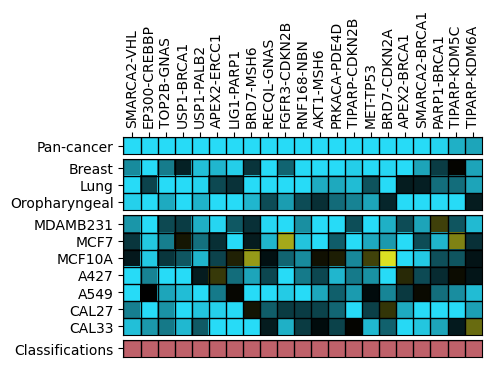

In [14]:
pancan_hmap = plot_pancancer_sl_heatmap(data, "")

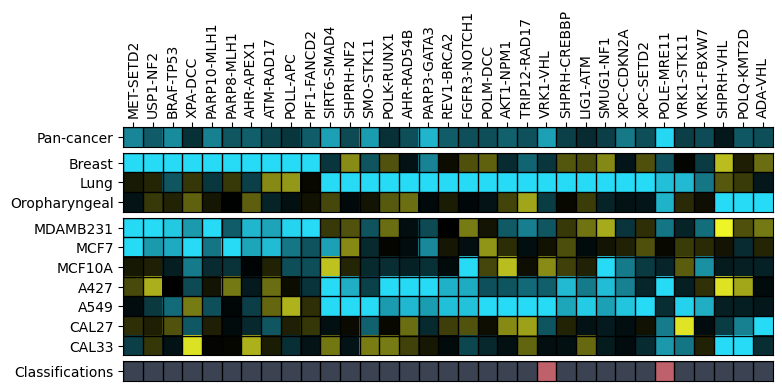

In [15]:
tissue_hmap = plot_tissue_sl_heatmap(data, "")